In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42


In [2]:
CSV_PATH = "/content/Share_of_the_population_with_incomes_below_the_subsistence_level.csv"

def robust_read(path):
    tried = []
    for sep in [",", "\t", ";", "|"]:
        for enc in ["utf-8", "utf-16", "cp1251", "latin1"]:
            try:
                df = pd.read_csv(path, sep=sep, encoding=enc, low_memory=False)
                if df.shape[1] > 1:
                    print("Read OK:", {"sep": sep, "encoding": enc})
                    return df
            except Exception as e:
                tried.append((sep, enc, str(e)))
    raise RuntimeError(f"Failed to read file. First attempts: {tried[:4]} ...")

df_raw = robust_read(CSV_PATH)
display(df_raw.head(10))
df_raw.info()


Read OK: {'sep': '\t', 'encoding': 'utf-8'}


,NAM,DAT,PERIOD,ӘАОЖ(каталог бойынша),LӘАОЖ(каталог бойынша),ОЖА,LОЖА,VAL
0,Share of the population with incomes below the...,1 квартал 2011 г.,201103,REPUBLIC OF KAZAKHSTAN,0,countryside,0,9.2
1,Share of the population with incomes below the...,2 квартал 2011 г.,201106,REPUBLIC OF KAZAKHSTAN,0,countryside,0,9.5
2,Share of the population with incomes below the...,1 квартал 2015 г.,201503,REPUBLIC OF KAZAKHSTAN,0,countryside,0,4.6
3,Share of the population with incomes below the...,2 квартал 2015 г.,201506,REPUBLIC OF KAZAKHSTAN,0,countryside,0,4.6
4,Share of the population with incomes below the...,3 квартал 2015 г.,201509,REPUBLIC OF KAZAKHSTAN,0,countryside,0,4.3
5,Share of the population with incomes below the...,4 квартал 2015 г.,201512,REPUBLIC OF KAZAKHSTAN,0,countryside,0,4.1
6,Share of the population with incomes below the...,2 квартал 2016 г.,201606,REPUBLIC OF KAZAKHSTAN,0,countryside,0,4.5
7,Share of the population with incomes below the...,3 квартал 2016 г.,201609,REPUBLIC OF KAZAKHSTAN,0,countryside,0,4.4
8,Share of the population with incomes below the...,4 квартал 2016 г.,201612,REPUBLIC OF KAZAKHSTAN,0,countryside,0,4.0
9,Share of the population with incomes below the...,1 квартал 2014 г.,201403,REPUBLIC OF KAZAKHSTAN,0,countryside,0,5.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2758 entries, 0 to 2757
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NAM                     2758 non-null   object 
 1   DAT                     2758 non-null   object 
 2   PERIOD                  2758 non-null   int64  
 3   ӘАОЖ(каталог бойынша)   2758 non-null   object 
 4   LӘАОЖ(каталог бойынша)  2758 non-null   int64  
 5   ОЖА                     2758 non-null   object 
 6   LОЖА                    2758 non-null   int64  
 7   VAL                     2758 non-null   float64
dtypes: float64(1), int64(3), object(4)
memory usage: 172.5+ KB


In [3]:
df = df_raw.copy()

df.columns = (df.columns
              .str.strip()
              .str.replace("\u00A0", "", regex=False)
              .str.replace(r"\s+", " ", regex=True))

col_region = next((c for c in df.columns if "каталог" in c.lower()), None) \
    or next((c for c in df.columns if c.lower() in ["region","область","регион"]), None)
col_value  = next((c for c in df.columns if c.lower() in ["val","value","значение"]), None)
col_year   = next((c for c in df.columns if c.lower() in ["dat","date","год","year"]), None)
col_period = next((c for c in df.columns if c.lower() in ["period","период"]), None)

assert col_value is not None, "Не нашёл числовой столбец (VAL/value)."

# значение -> число
df[col_value] = (df[col_value].astype(str)
                 .str.replace(" ", "", regex=False)
                 .str.replace(",", ".", regex=False)
                 .str.replace(r"[^\d\.\-]", "", regex=True))
df[col_value] = pd.to_numeric(df[col_value], errors="coerce")

def extract_year_series(s):
    y = s.astype(str).str.extract(r"(\d{4})")[0]
    return pd.to_numeric(y, errors="coerce")

df["year"] = np.nan
if col_year and df[col_year].notna().any():
    df["year"] = extract_year_series(df[col_year])
if df["year"].isna().all() and col_period:
    df["year"] = extract_year_series(df[col_period])

if col_period:
    s = df[col_period].astype(str)
    m6 = s.str.extract(r"(\d{6})")[0]
    if m6.notna().any():
        df["month"] = pd.to_numeric(m6.str[-2:], errors="coerce")
    else:
        q = s.str.extract(r"(\d)\s*квартал", flags=re.IGNORECASE)[0]
        df["month"] = pd.to_numeric(q, errors="coerce").map({1:2, 2:5, 3:8, 4:11})
else:
    df["month"] = np.nan
df["month"] = df["month"].fillna(6).astype(int)      # середина года по умолчанию

# region
if col_region is None:
    col_region = "REGION"
    df[col_region] = "Total"

df_prep = (df[[col_region, "year", "month", col_value]]
           .rename(columns={col_region:"region", col_value:"target"})
           .dropna(subset=["region","year","target"])
           .copy())

mask_allkz = df_prep["region"].str.upper().isin(
    ["REPUBLIC OF KAZAKHSTAN", "КАЗАХСТАН РЕСПУБЛИКАСЫ", "РЕСПУБЛИКА КАЗАХСТАН"]
)
df_prep = df_prep[~mask_allkz].reset_index(drop=True)

print("Prepared sample:")
display(df_prep.head())
print("Years:", int(df_prep["year"].min()), "-", int(df_prep["year"].max()),
      "| Regions:", df_prep["region"].nunique())


Prepared sample:


,region,year,month,target
0,KOSTANAY REGION,2011,3,5.4
1,KOSTANAY REGION,2011,6,4.1
2,KOSTANAY REGION,2015,3,2.4
3,KOSTANAY REGION,2015,6,2.9
4,KOSTANAY REGION,2015,9,2.9


Years: 2011 - 2025 | Regions: 21


Shapes → Train: (2101, 5)  Test: (456, 5)


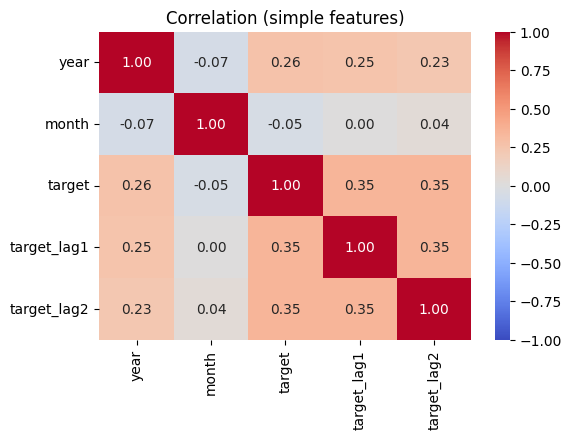

In [4]:
feat = df_prep.sort_values(["region","year","month"]).copy()
feat["target_lag1"] = feat.groupby("region")["target"].shift(1)
feat["target_lag2"] = feat.groupby("region")["target"].shift(2)

# удаляем строки без необходимых лагов
feat_simple = feat.dropna(subset=["target_lag1","target_lag2"]).copy()

# time index и сплит 80/20 по времени
feat_simple["period_num"] = feat_simple["year"]*100 + feat_simple["month"]
thr = np.quantile(feat_simple["period_num"], 0.80)
train_mask = feat_simple["period_num"] <= thr
test_mask  = feat_simple["period_num"]  > thr

cat_features = ["region"]
num_features = ["year","month","target_lag1","target_lag2"]

X_train = feat_simple.loc[train_mask, cat_features + num_features]
y_train = feat_simple.loc[train_mask, "target"]
X_test  = feat_simple.loc[test_mask,  cat_features + num_features]
y_test  = feat_simple.loc[test_mask,  "target"]

print("Shapes → Train:", X_train.shape, " Test:", X_test.shape)

plt.figure(figsize=(6,4))
sns.heatmap(feat_simple[["year","month","target","target_lag1","target_lag2"]].corr(),
            cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Correlation (simple features)")
plt.show()


In [5]:
def plot_actual_vs_pred(X_test, y_test, y_pred, title=""):
    test_df = X_test.copy().reset_index(drop=True)
    test_df["y_true"] = y_test.reset_index(drop=True).values
    test_df["y_pred"] = pd.Series(y_pred).reset_index(drop=True)
    test_df["period_num"] = (test_df["year"].astype(int)*100 +
                             test_df["month"].astype(int))

    top_region = test_df["region"].value_counts().idxmax()
    plot_df = test_df[test_df["region"] == top_region].sort_values("period_num")

    plt.figure(figsize=(10,5))
    plt.plot(plot_df["period_num"], plot_df["y_true"], marker="o", label="Actual")
    plt.plot(plot_df["period_num"], plot_df["y_pred"], marker="x", label="Predicted")
    plt.xlabel("Period (YYYYMM)"); plt.ylabel("Share below subsistence, %")
    plt.title(f"{title} — Actual vs Predicted (region = {top_region})")
    plt.legend(); plt.tight_layout(); plt.show()


KNN (k=5) | MAE=1.018  RMSE=1.548  R2=0.581


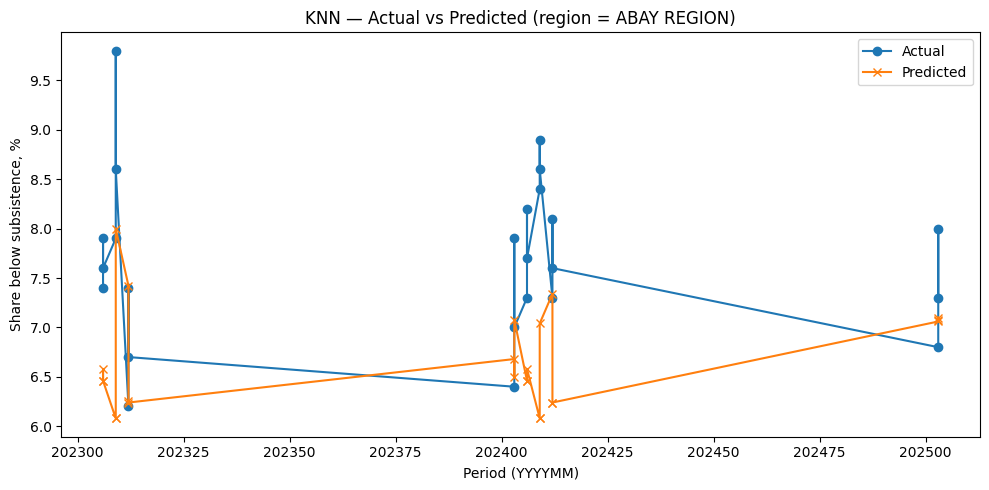

In [6]:
from sklearn.neighbors import KNeighborsRegressor

prep_knn = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["region"]),
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]), num_features),
])

knn = Pipeline([
    ("prep",  prep_knn),
    ("model", KNeighborsRegressor(n_neighbors=5, weights="uniform", p=2)),
])

knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

knn_mae  = mean_absolute_error(y_test, knn_pred)
knn_rmse = mean_squared_error(y_test, knn_pred)**0.5
knn_r2   = r2_score(y_test, knn_pred)
print(f"KNN (k=5) | MAE={knn_mae:.3f}  RMSE={knn_rmse:.3f}  R2={knn_r2:.3f}")

plot_actual_vs_pred(X_test, y_test, knn_pred, title="KNN")


DecisionTree | MAE=1.157  RMSE=1.849  R2=0.402


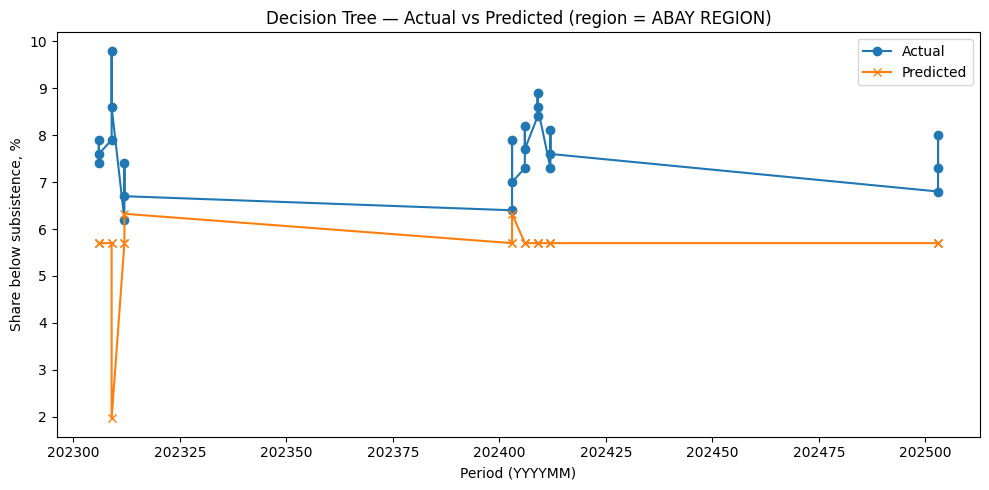

In [7]:
from sklearn.tree import DecisionTreeRegressor

prep_dt = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["region"]),
    ("num", SimpleImputer(strategy="median"), num_features),
])

dt = Pipeline([
    ("prep",  prep_dt),
    ("model", DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=None, min_samples_leaf=3)),
])

dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

dt_mae  = mean_absolute_error(y_test, dt_pred)
dt_rmse = mean_squared_error(y_test, dt_pred)**0.5
dt_r2   = r2_score(y_test, dt_pred)
print(f"DecisionTree | MAE={dt_mae:.3f}  RMSE={dt_rmse:.3f}  R2={dt_r2:.3f}")

plot_actual_vs_pred(X_test, y_test, dt_pred, title="Decision Tree")


RandomForest | MAE=1.018  RMSE=1.583  R2=0.562


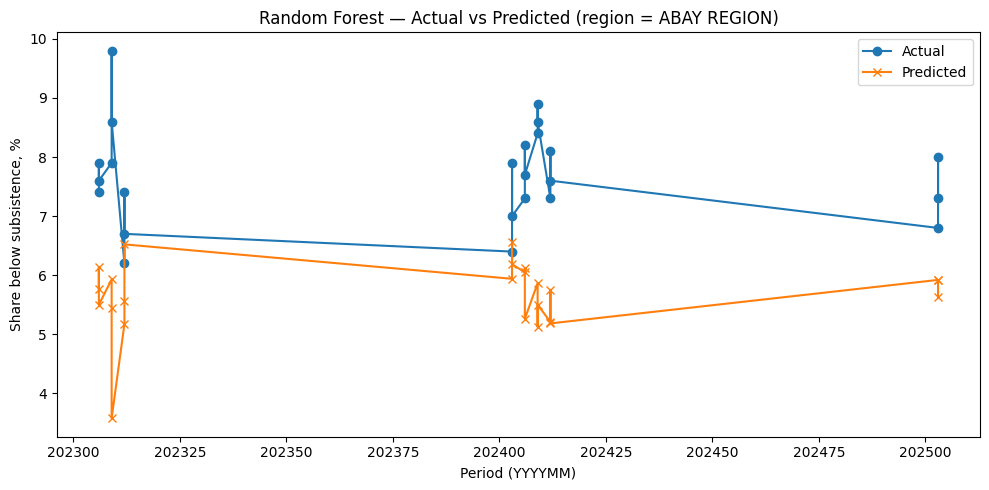

In [8]:
from sklearn.ensemble import RandomForestRegressor

prep_rf = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["region"]),
    ("num", SimpleImputer(strategy="median"), num_features),
])

rf = Pipeline([
    ("prep",  prep_rf),
    ("model", RandomForestRegressor(
        n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)),
])

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_mae  = mean_absolute_error(y_test, rf_pred)
rf_rmse = mean_squared_error(y_test, rf_pred)**0.5
rf_r2   = r2_score(y_test, rf_pred)
print(f"RandomForest | MAE={rf_mae:.3f}  RMSE={rf_rmse:.3f}  R2={rf_r2:.3f}")

plot_actual_vs_pred(X_test, y_test, rf_pred, title="Random Forest")


In [9]:
summary = (pd.DataFrame([
    ["KNN (k=5)",     knn_mae, knn_rmse, knn_r2],
    ["Decision Tree", dt_mae,  dt_rmse,  dt_r2],
    ["Random Forest", rf_mae,  rf_rmse,  rf_r2],
], columns=["Model","MAE","RMSE","R2"])
          .sort_values("R2", ascending=False)
          .reset_index(drop=True))

summary


,Model,MAE,RMSE,R2
0,KNN (k=5),1.018202,1.547954,0.580812
1,Random Forest,1.017975,1.583165,0.561525
2,Decision Tree,1.157339,1.848807,0.402035


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# Define numerical and categorical features
num_features = ["year","month","target_lag1","target_lag2"]
cat_features = ["region"]

# Separate features
X_train_num = X_train[num_features]
X_test_num = X_test[num_features]
X_train_cat = X_train[cat_features]
X_test_cat = X_test[cat_features]

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

# One-hot encode categorical features
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # Use sparse_output=False for dense output
X_train_onehot = onehot_encoder.fit_transform(X_train_cat)
X_test_onehot = onehot_encoder.transform(X_test_cat)

# Combine scaled numerical and one-hot encoded categorical features
X_train_processed = np.concatenate((X_train_scaled, X_train_onehot), axis=1)
X_test_processed = np.concatenate((X_test_scaled, X_test_onehot), axis=1)

print("Shape after manual preprocessing (train):", X_train_processed.shape)
print("Shape after manual preprocessing (test):", X_test_processed.shape)

# Reshape the data for the Conv1D layer
X_train_reshaped = np.expand_dims(X_train_processed, axis=2)
X_test_reshaped = np.expand_dims(X_test_processed, axis=2)

print("Shape after expand_dims (train):", X_train_reshaped.shape)
print("Shape after expand_dims (test):", X_test_reshaped.shape)

# Define the CNN model
model = Sequential([
    Input(shape=(X_train_reshaped.shape[1], 1)), # Explicitly define input layer shape
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train_reshaped, y_train, epochs=30, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=1)

loss, mae = model.evaluate(X_test_reshaped, y_test)
print(f"Test MAE: {mae:.3f}")

# plot_actual_vs_pred(X_test, y_test, model.predict(X_test_reshaped).flatten(), title="CNN") # Need to fix this plotting function call

Shape after manual preprocessing (train): (2101, 25)
Shape after manual preprocessing (test): (456, 25)
Shape after expand_dims (train): (2101, 25, 1)
Shape after expand_dims (test): (456, 25, 1)
Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 11.6837 - mae: 2.6151 - val_loss: 5.7789 - val_mae: 1.7924
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9761 - mae: 1.7051 - val_loss: 5.8794 - val_mae: 1.7764
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4376 - mae: 1.6030 - val_loss: 5.6254 - val_mae: 1.7118
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.6997 - mae: 1.6028 - val_loss: 5.3621 - val_mae: 1.6631
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0493 - mae: 1.5192 - val_loss: 5.2775 - val_mae: 1.6613
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2347 - mae: 1.5510 - val_loss: 5.1174 - val_mae: 1.6451
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8822 - mae: 1.4938 - val_loss: 5.0904 - val_mae

In [11]:
# --- ЯЧЕЙКА: Сохранение моделей, метрик, requirements и упаковка в ZIP ---
import joblib, json, zipfile, os
from datetime import datetime

# --- 1) Сохраняем sklearn pipelines (если они в окружении) ---
# убедись, что переменные knn, dt, rf и model (Keras) доступны в namespace
artifacts = []

try:
    joblib.dump(knn, "model_knn.pkl")
    artifacts.append("model_knn.pkl")
    print("Saved model_knn.pkl")
except Exception as e:
    print("Кнопка: не удалось сохранить knn:", e)

try:
    joblib.dump(dt, "model_dt.pkl")
    artifacts.append("model_dt.pkl")
    print("Saved model_dt.pkl")
except Exception as e:
    print("Кнопка: не удалось сохранить dt:", e)

try:
    joblib.dump(rf, "model_rf.pkl")
    artifacts.append("model_rf.pkl")
    print("Saved model_rf.pkl")
except Exception as e:
    print("Кнопка: не удалось сохранить rf:", e)

# Если у тебя есть обученный Keras model (CNN), сохраним .h5
try:
    # model - переменная твоей нейросети в ноутбуке
    model.save("model_cnn.h5")
    artifacts.append("model_cnn.h5")
    print("Saved model_cnn.h5")
except Exception as e:
    print("Keras save skipped or failed (maybe model not defined):", e)

# --- 2) Сохраняем метрики (используем переменные, которые ты уже вычислил) ---
metrics = {
    "knn": {"MAE": float(knn_mae), "RMSE": float(knn_rmse), "R2": float(knn_r2)},
    "decision_tree": {"MAE": float(dt_mae), "RMSE": float(dt_rmse), "R2": float(dt_r2)},
    "random_forest": {"MAE": float(rf_mae), "RMSE": float(rf_rmse), "R2": float(rf_r2)}
}
# если CNN есть, можно добавить:
try:
    metrics["cnn"] = {"MAE": float(mae)}  # используй имя переменной, где сохранился mae из evaluate
except Exception:
    pass

with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)
artifacts.append("metrics.json")
print("Saved metrics.json")

# --- 3) Создадим простой requirements.txt (динамически) ---
reqs = [
    f"scikit-learn=={__import__('sklearn').__version__}",
    f"pandas=={__import__('pandas').__version__}",
    f"joblib=={__import__('joblib').__version__}",
    # tensorflow may be heavy — include only if used
]
# попытка добавить tensorflow если установлен
try:
    import tensorflow as _tf
    reqs.append(f"tensorflow=={_tf.__version__}")
except Exception:
    pass

with open("requirements.txt", "w") as f:
    f.write("\n".join(reqs))
artifacts.append("requirements.txt")
print("Saved requirements.txt")

# --- 4) README (короткий) ---
readme_text = f"""Assignment 4 — Models (auto-generated)
Date: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')}

Содержимое архива:
- model_knn.pkl, model_dt.pkl, model_rf.pkl (sklearn pipelines)
- model_cnn.h5 (Keras model) — если присутствует
- metrics.json — метрики для моделей
- requirements.txt — ключевые зависимости
- midterm.ipynb (основной ноутбук) — НЕ включается автоматически, при упаковке ниже добавьте его, если хотите
"""
with open("README_assignment4.txt","w", encoding="utf-8") as f:
    f.write(readme_text)
artifacts.append("README_assignment4.txt")
print("Saved README_assignment4.txt")

# --- 5) Упакуем всё в ZIP (включай midterm.ipynb если хочешь) ---
zip_name = "assignment4_final.zip"
with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as z:
    # добавим все артефакты
    for fn in artifacts:
        if os.path.exists(fn):
            z.write(fn)
    # добавим датасет (если он в текущей папке)
    ds = CSV_PATH if os.path.exists(CSV_PATH) else ("Share_of_the_population_with_incomes_below_the_subsistence_level.csv" if os.path.exists("Share_of_the_population_with_incomes_below_the_subsistence_level.csv") else None)
    if ds:
        z.write(ds)
    # добавим сам ноутбук (если он в cwd)
    nb = next((f for f in os.listdir(".") if f.lower().endswith(".ipynb") and "midterm" in f.lower()), None)
    if nb:
        z.write(nb)
print("Created", zip_name)
print("Included files:", artifacts, "dataset:", ds, "notebook:", nb)


Saved model_knn.pkl
Saved model_dt.pkl


Saved model_rf.pkl
Saved model_cnn.h5
Saved metrics.json
Saved requirements.txt
Saved README_assignment4.txt


/tmp/ipython-input-1557127705.py:77: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Date: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')}


Created assignment4_final.zip
Included files: ['model_knn.pkl', 'model_dt.pkl', 'model_rf.pkl', 'model_cnn.h5', 'metrics.json', 'requirements.txt', 'README_assignment4.txt'] dataset: /content/Share_of_the_population_with_incomes_below_the_subsistence_level.csv notebook: None
